# Урок 4. Деревья решений

## Домашнее задание

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)  
2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

### Критерии останова

_Критерии останова_ - это критерии, которые показывают, нужно ли остановить процесс построения дерева. Правильный выбор критериев останова роста дерева может существенно повлиять на его качество. Существует большое количество возможных ограничений:

- Ограничение максимальной глубины дерева. Этот критерий считается достаточно грубым, но хорошо зарекомендовавшим себя в построении композиций деревьев - когда несколько деревьев объединяются в один алгоритм.


- Ограничение максимального количества листьев.


- Ограничение минимального количества $n$ объектов в листе. При этом оно должно быть достаточным, чтобы построить надежный прогноз.


- Останов в случае, когда все объекты в листе относятся к одному классу.


- Требование улучшения функционала качества при разбиении на какую-то минимальную величину.

Подбор оптимальных критериев - сложная задача, которая обычно решается методом кросс-валидации.

In [1]:
import random

from sklearn import datasets

import numpy as np

import warnings
warnings.simplefilter('ignore')

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# сгенерируем данные
regression_data, regression_target = datasets.make_regression(n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 0.1, random_state = 2)

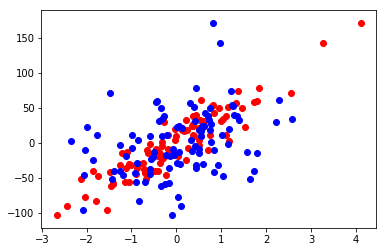

In [4]:
# визуализируем сгенерированные данные

pylab.scatter(regression_data[:,0], regression_target, color = 'r')
pylab.scatter(regression_data[:,1], regression_target, color = 'b')

In [5]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # расчет среднего по всем объектам, которые находятся в узле: 
        prediction = np.mean(self.labels)
        return prediction        

In [7]:
# Расчет дисперcии
def dispersion_criterion(target):
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    target_mean = np.mean(target)
    
    summa = 0
    for i in target:
        summa += (i - target_mean)**2
    print(summa)
    
    print(target_mean)
    print(target.max(), target.min())
    impurity = summa / target.shape[0]
        
    return impurity

dispersion_criterion(regression_target)

208425.29647605465
-0.30038259716287746
171.10061676019984 -103.03230984661417


2084.2529647605465

In [8]:
# Расчет качества

def quality(left_labels, right_labels, current_dispersion):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_dispersion - p * dispersion_criterion(left_labels) - (1 - p) * dispersion_criterion(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
#     min_leaf = 5

    current_dispersion = dispersion_criterion(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_samples_leaf, max_depth):

    quality, t, index = find_best_split(data, labels, min_samples_leaf)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    if max_depth == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    max_depth -= 1
    true_branch = build_tree(true_data, true_labels, min_samples_leaf, max_depth)
    false_branch = build_tree(false_data, false_labels, min_samples_leaf, max_depth)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    targets = []
    for obj in data:
        prediction = classify_object(obj, tree)
        targets.append(prediction)
    return targets

In [16]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_data, 
                                                                                     regression_target, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

## Реализовал 2 критерия останова:  
максимальная глубина  - max_depth  
минимальное количество объектов в узле min_samples_leaf

In [17]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, min_samples_leaf=10, max_depth=1)

114984.4948935884
-0.7191590101338393
142.14047452428244 -96.09724605203945
30952.376521082333
-25.39694827113001
34.281521929093394 -96.09724605203945
30401.41959600036
30.32709199563554
142.14047452428244 -24.813797265541425
8107.147063730885
-46.64066811711355
-13.593866787831159 -96.09724605203945
63139.58489463694
12.88721405860089
142.14047452428244 -45.52218302747992
8481.842809586322
-45.12716316328554
-13.593866787831159 -96.09724605203945
58717.85882608694
14.652842427495596
142.14047452428244 -45.52218302747992
49767.147872282956
-15.89712799850406
39.39219473411835 -96.09724605203945
21931.896962116854
40.02170511654412
142.14047452428244 -9.991627282507947
11775.111346015618
-40.11968499696804
-2.1852353967715885 -96.09724605203945
53403.170422981864
17.339415400498506
142.14047452428244 -45.52218302747992
26079.023946065998
-29.201555719293477
34.281521929093394 -96.09724605203945
35273.03552893583
26.18088232629471
142.14047452428244 -24.813797265541425
24408.65924481288

In [18]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.33882196602919634
--> True:
  Прогноз: -37.02505547965431
--> False:
  Прогноз: 22.077566680030177


In [19]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [20]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [21]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2) # <=> 1/n * np.sum((y_pred - y)**2)
    return err

In [22]:
# Точность на обучающей выборке
train_mse = calc_mse(train_labels, train_answers)
train_mse

814.9800785858247

In [23]:
# Точность на тестовой выборке
test_mse = calc_mse(test_labels, answers)
test_mse

1495.5574605345075

In [24]:
from sklearn.metrics import r2_score
r2_score(train_labels, train_answers), r2_score(test_labels, answers)

(0.5038582762501765, 0.5196276129190641)

In [25]:
my_tree = build_tree(train_data, train_labels, min_samples_leaf=5, max_depth=10)
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)

114984.4948935884
-0.7191590101338393
142.14047452428244 -96.09724605203945
30952.376521082333
-25.39694827113001
34.281521929093394 -96.09724605203945
30401.41959600036
30.32709199563554
142.14047452428244 -24.813797265541425
8107.147063730885
-46.64066811711355
-13.593866787831159 -96.09724605203945
63139.58489463694
12.88721405860089
142.14047452428244 -45.52218302747992
4734.172538015309
-58.9780165919219
-14.37505948153154 -96.09724605203945
83851.80968096702
5.75404738784261
142.14047452428244 -56.42811287217322
8481.842809586322
-45.12716316328554
-13.593866787831159 -96.09724605203945
58717.85882608694
14.652842427495596
142.14047452428244 -45.52218302747992
49767.147872282956
-15.89712799850406
39.39219473411835 -96.09724605203945
21931.896962116854
40.02170511654412
142.14047452428244 -9.991627282507947
11775.111346015618
-40.11968499696804
-2.1852353967715885 -96.09724605203945
53403.170422981864
17.339415400498506
142.14047452428244 -45.52218302747992
26079.023946065998
-29

2117.6289136445994
8.256552634285892
34.281521929093394 -19.54282045869436
40444.5496937157
23.896121159733372
142.14047452428244 -45.52218302747992
8601.821276121296
4.582048313975576
34.281521929093394 -45.52218302747992
24621.209392253135
35.92818538649007
142.14047452428244 -9.991627282507947
7832.035226685472
3.272154649895038
34.281521929093394 -45.52218302747992
26799.55601468654
33.22151454973989
142.14047452428244 -9.991627282507947
9697.475982971264
6.472035149787408
38.26581691209621 -45.52218302747992
23949.569253401285
36.97375586798919
142.14047452428244 -9.991627282507947
18164.57195710819
12.95717427286957
61.944771108707215 -45.52218302747992
11965.998209351515
56.53238244041471
142.14047452428244 10.764375851206657
6990.626485356183
5.144551444257471
34.281521929093394 -45.52218302747992
30047.36423870144
31.148824842051273
142.14047452428244 -24.813797265541425
8800.66064104439
0.3108132186231032
70.91720316252032 -45.52218302747992
30185.597294759886
27.052824614066

1125.2190356936715
23.427246382308144
38.26581691209621 1.821847946200574
570.104665702196
11.122071383888532
24.650832436100693 -4.849712205269187
1123.5347275087565
23.274298125584075
38.26581691209621 1.821847946200574
706.8190075394374
10.904056693849997
24.650832436100693 -4.849712205269187
521.0988968821981
27.688398189546813
38.26581691209621 11.063023350738472
706.8419806285305
10.918508208112586
24.650832436100693 -4.849712205269187
166.71130295318474
4.432122661513651
11.063023350738472 -4.849712205269187
154.45970096667628
16.323829496945034
24.650832436100693 9.59207398533517
325.6419676806263
6.733793538126565
18.242147921191126 -4.849712205269187
150.04376627451387
15.940165812095813
24.650832436100693 9.59207398533517
288.3450518364998
7.523960274124251
18.04950099873323 -4.849712205269187
312.86983509403956
13.747298153102863
24.650832436100693 1.821847946200574
292.99251775780635
7.917553377100174
18.04950099873323 -4.849712205269187
294.97382822007125
14.5196540053274

In [26]:
print_tree(my_tree)

Индекс 0
Порог -0.33882196602919634
--> True:
  Индекс 0
  Порог -1.4212172273041268
  --> True:
    Прогноз: -66.41184277698694
  --> False:
    Индекс 1
    Порог -0.5834145945790076
    --> True:
      Прогноз: -43.501005432325975
    --> False:
      Индекс 0
      Порог -0.7478709492938624
      --> True:
        Прогноз: -27.36871292596803
      --> False:
        Прогноз: -12.958116642453108
--> False:
  Индекс 0
  Порог 1.1178867334508418
  --> True:
    Индекс 1
    Порог -0.49817419392175855
    --> True:
      Индекс 0
      Порог 0.21611600626368202
      --> True:
        Прогноз: -24.334050815458298
      --> False:
        Прогноз: 2.0481848189934717
    --> False:
      Индекс 0
      Порог 0.39652015868670865
      --> True:
        Индекс 1
        Порог 1.0198547293692373
        --> True:
          Индекс 0
          Порог 9.761471596093479e-06
          --> True:
            Прогноз: 4.432122661513651
          --> False:
            Прогноз: 16.323829496945034
   

In [27]:
r2_score(train_labels, train_answers), r2_score(test_labels, answers)

(0.8740294155339386, 0.7796399647553528)